In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import astropy.coordinates as astro_coord
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#sns.set_style("dark")

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
#mpl.rcParams['axes.labelsize'] = 20
#mpl.rcParams['xtick.labelsize'] =20
#mpl.rcParams['ytick.labelsize'] = 20
#mpl.rcParams['legend.fontsize'] = 20
#mpl.rcParams['figure.titlesize'] = 20
import pymc3 as pm
from astropy.coordinates import Angle
import astropy.table as astrotable

splat.initializeStandards(all=True)
from scipy.interpolate import griddata, interpn
import splat.empirical as spe
%matplotlib inline


Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
PS1_DEPTHS={ 'Y':21.4} #'R':23.2, 'I':23.1  'Z':22.3 something funny happening
SDSS_DEPTHS={'Z':20.5} #R':22.2, 'I':21.3,
VISTA_DEPTHS={'KS':17.9} #'J':19.5, 'H':18.6,
color_cuts={#'SDSS_G-SDSS_R':(1.6, 'greater'),
            'SDSS_R-SDSS_I': (1.0, 'greater'),
            'SDSS_I-SDSS_Z': (0.5, 'greater'),
            'SDSS_R-SDSS_Z': (1.6, 'greater'),
            'SDSS_I-VISTA_J':(1.7, 'greater'),
            'SDSS_Z-VISTA_J':(1.1, 'greater'),
            'VISTA_J-VISTA_KS':(0.75, 'less')} 
OTHER_CUTS={'SDSS_R': 22.2, 
           'SDSS_I': 21.3,
            'PANSTARRS_R': 23.2,
            'PANSTARRS_I':23.1,
            'PANSTARRS_Z':22.3,
            'VISTA_J':19.3,
            'VISTA_H':18.6}

In [3]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [4]:
#DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [5]:
#t1    = astrotable.Table.read(DATA_FOLDER+'Stripe_Defs6_ctheissen.fit') # open an FITS file
#t2    = astrotable.Table.read(DATA_FOLDER+'FieldNums_ctheissen.fit') # open an FITS file
#t3    = astrotable.join(t1, t2, keys='fieldid').to_pandas()

In [6]:
import glob

In [7]:
from astropy.io.votable import parse_single_table

In [8]:
#forget about sdss use
ffolder='/users/caganze/research/popsims/data/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [9]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)

In [10]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [11]:
footprint=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [12]:
a=Angle(footprint.ra.to(u.radian))
b=Angle(footprint.dec.to(u.radian))
a.wrap_at('180d', inplace=True)
b.wrap_at('180d', inplace=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


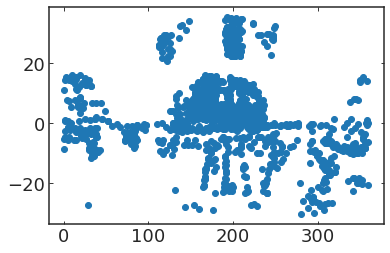

In [13]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [14]:
def interpolated(ra, dec, interpolators):
    #Ra dec must in degrees wrapped at 180 degree
    interpoints=np.array([interpolators[0], interpolators[1] ]).T
    return griddata(interpoints, interpolators[-1] , (ra, dec), \
                    method='cubic', fill_value=-1.)
def interpolated_broken(ra, dec,interpolators):
    interpoints=np.array([interpolators[0], interpolators[1] ])
    return  interpn(list(zip(interpoints)), interpolators[-1] , (ra, dec),\
                     fill_value=-1.,  bounds_error=False) 

In [15]:
#from popsims.widefields import  WideField, create_mixed_population,\
#transform_tocylindrical

In [16]:
#field= WideField(footprinttype='uniform')
#field.footprint=SDSS
#trace=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=1000)

In [17]:
thin_dist_list=[]
thick_dist_list=[]
halo_dist_list=[]
discr_ls=[]
discr_bs=[]

for i in tqdm(np.arange(1000)):
    c=sdsscoord[np.random.choice(len(sdsscoord))]
    narro_field=popsims.Pointing(coord=c)
    halo_field=popsims.Pointing(coord=c, density='spheroid')

    narro_field.mag_limits=dict(zip(['VISTA_{}'.format(k) for k in VISTA_DEPTHS.keys()],\
             [(0, VISTA_DEPTHS[k]) for k in VISTA_DEPTHS.keys()]))
    thin_dist_list +=list(narro_field.draw_distances(0.1, 1000,350,  nsample=1e3))
    thick_dist_list +=list(narro_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    halo_dist_list +=list(halo_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    discr_ls += [c.galactic.l.value]
    discr_bs += [c.galactic.b.value]

In [18]:
#np.save('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy',\
#        {'thind':thin_dist_list ,\
#         'thickd':thick_dist_list ,\
#         'halod': halo_dist_list,\
#         'l': discr_ls ,\
#         'b': discr_bs}, allow_pickle=True)

In [19]:
grid=np.arange(14, 40)

In [20]:
dictionary=np.load('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy', allow_pickle=True)
dist_dictionary=dictionary.flatten()[0]
thin_dist_list= dist_dictionary['thind']
thick_dist_list= dist_dictionary['thickd']
halo_dist_list= dist_dictionary['halod']
discr_ls = dist_dictionary['l']
discr_bs = dist_dictionary['b']

In [21]:
max_distances={}
for g in grid:
    pol=popsims.POLYNOMIALS['absmags']['dwarfs']['VISTA_J']['fit']
    max_distances[g]=popsims.get_distance(pol(g), 19.5)

In [22]:
max_distances

{14: 1351.1800415592597,
 15: 994.5775509203132,
 16: 751.775828013973,
 17: 582.8823947879538,
 18: 462.7759802833678,
 19: 375.49084606930705,
 20: 310.7518582584911,
 21: 261.85047467092903,
 22: 224.3386219106849,
 23: 195.21795514909255,
 24: 172.42971478137414,
 25: 154.5280956816413,
 26: 140.4661433057278,
 27: 129.45014708895974,
 28: 120.83423217816366,
 29: 114.0364359809807,
 30: 108.46468696508312,
 31: 103.44924785977229,
 32: 98.19123449797792,
 33: 91.75803416096211,
 34: 83.1829903805796,
 35: 71.73716910175997,
 36: 57.38283484207196,
 37: 41.23198027458584,
 38: 25.57416522248665,
 39: 13.04076608724041}

In [23]:
def resample_distance(df, dmax_dict, population ):
    df['d']=np.nan
    if population=='thin_disk':
        ds=np.array(thin_dist_list)
    if population=='thick_disk':
        ds=np.array(thick_dist_list)
    if population=='halo':
        ds=np.array(halo_dist_list)
    ds=np.array(ds)
    df['spt_r']=np.round(df.spt)
    
    dx= ds[ds< dmax_dict[float(df.spt_r.iloc[0])] ]
    df['d']= np.random.choice(dx, len(df))
    return df
def sample_distance_properly(df, dmax_dict, population='thin_disk'):
    df['spt_r']=np.round(df.spt)
    groups=[]
    for g in tqdm( df.groupby('spt_r')):
        groups.append(resample_distance(g[1], dmax_dict, population))
    return pd.concat(groups)
def interpolate_sdss(ra, dec):
    interpolators=[a.to(u.degree).value, b.to(u.degree).value, np.ones_like(a)]
    return interpolated(ra, dec, interpolators )
def apply_sdss_selection(df):
    entiregalaxy=SkyCoord(l=df.l*u.radian,\
                     b=df.b*u.radian, frame='galactic')
    
    gridra=Angle(entiregalaxy.icrs.ra.to(u.radian))
    gridra.wrap_at('180d', inplace=True)
    griddec=Angle(entiregalaxy.icrs.dec.to(u.radian))
    griddec.wrap_at('180d', inplace=True)

    selectionfunction=interpolate_sdss(gridra.to(u.degree).value, \
                                                  griddec.to(u.degree).value)
    df['SDSS_selection']= selectionfunction
    df['ra']=gridra
    df['dec']=griddec
    return df

def apply_color_cuts(df):
    bools=[]
    for k in color_cuts.keys():
        xkey, ykey= k.split('-')
        if color_cuts[k][-1]=='greater':
            bools.append(df['abs_{}'.format(xkey)]-df['abs_{}'.format(ykey)] >= color_cuts[k][0])
        if color_cuts[k][-1]=='less':
            print (k)
            bools.append(df['abs_{}'.format(xkey)]-df['abs_{}'.format(ykey)] <= color_cuts[k][0])
    return np.logical_and.reduce(bools)
    

In [24]:
mag_keys0=['VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Z', \
'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'SDSS_R', 'SDSS_I', 'SDSS_Z', \
           'PANSTARRS_R', 'PANSTARRS_Z', 'PANSTARRS_I', 'PANSTARRS_Y']

In [25]:
def apply_all_magnitude_color_cuts(df):
    other_bools=[]
    for k in PS1_DEPTHS.keys():
        other_bools.append((df['PANSTARRS_{}'.format(k)]<PS1_DEPTHS[k]).values)
    for k in SDSS_DEPTHS.keys():
        other_bools.append((df['SDSS_{}'.format(k)]<SDSS_DEPTHS[k]).values)
    for k in VISTA_DEPTHS.keys():
        other_bools.append((df['VISTA_{}'.format(k)]<VISTA_DEPTHS[k]).values)
    tot_bools=np.logical_and.reduce(other_bools)
    #
    
    return tot_bools

In [26]:
def sample_distance_from_d3(dmax, nsample):
    ##random choice from d^3
    d=np.linspace(0.1, dmax, 1000)
    cdf=(d**3)/np.nanmax(d**3)
    return popsims.tools.random_draw(d, cdf, nsample=nsample)

In [27]:
#

In [28]:
#redra ibjects from halo thin or thick based on the max dista
def resample_by_max_distance(nsample=1e4):
    df_list=[]
    for k in max_distances.keys():
        if max_distances[k] >200:
            #make distance array array
            thin_dist_list_arr=np.array(thin_dist_list)
            thick_dist_list_arr=np.array(thick_dist_list)
            halo_dist_list_arr=np.array(halo_dist_list)
        else:
            thin_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
            thick_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
            halo_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
        
        
        #use metal-rich models but absolute mag relations for metal poor
        df_thin=popsims.create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample, \
            distances= thin_dist_list_arr[thin_dist_list_arr<2*max_distances[k]],\
                  poptype='dwarfs')
        
        df_thick=popsims.create_pop(bfraction=0.2,\
                          model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample, \
        distances= thick_dist_list_arr[thick_dist_list_arr<2*max_distances[k]],\
                         population='thick_disk', poptype='subdwarfs')
        
        df_halo=popsims.create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample,\
        distances= halo_dist_list_arr[halo_dist_list_arr<2*max_distances[k]],\
                         population='halo', poptype='subdwarfs')
        
        df_thin['population']='thin_disk'
        df_thick['population']='thick_disk' 
        df_halo['population']='halo'
        
        #make magnitudes and distance cuts righ aay
        thin_bool=np.logical_and.reduce([df_thin.spt>=k, df_thin.spt<k+1, \
                                         df_thin.d <2*max_distances[k]])
                                        #apply_all_magnitude_color_cuts(df_thin)])
        
        thick_bool=np.logical_and.reduce([df_thick.spt>=k, df_thick.spt<k+1, \
                                         df_thick.d <2*max_distances[k]])
                                         # apply_all_magnitude_color_cuts(df_thick)])
        
        halo_bool=np.logical_and.reduce([df_halo.spt>=k, df_halo.spt<k+1, \
                                         df_halo.d <2*max_distances[k]])
                                       #  apply_all_magnitude_color_cuts(df_halo)])
        
        print ('thin for spt {} {}'.format(k, len(df_thin.loc[thin_bool])))
        print ('thick for spt {} {}'.format(k, len(df_thick.loc[thick_bool])))
        print ('halo for spt {} {}'.format(k, len(df_halo.loc[halo_bool])))
        df_thin_small_df=(df_thin.loc[thin_bool]).reset_index(drop=True)
        df_thick_small_df=(df_thick.loc[thick_bool]).reset_index(drop=True)
        df_halo_small_df=(df_halo.loc[halo_bool]).reset_index(drop=True)
        
        df_list.append(pd.concat([df_thin_small_df.sample(n=int(nsample), replace=True), \
              df_thick_small_df.sample(n=int(nsample), replace=True), \
              df_halo_small_df.sample(n=int(nsample), replace=True)]).reset_index(drop=True))
        
        del df_thin_small_df
        del df_thick_small_df
        del df_halo_small_df
        
    df0=pd.concat(df_list)
    #use SD relations from Rocio for 
    df=popsims.pop_mags_from_type(df0.spt.values, d=df0.d.values, \
                keys=['SDSS_R', 'SDSS_I', 'SDSS_Z'], reference='kiman2019').join(df0, rsuffix='_rocio')
    df=df.drop(['abs_SDSS_R', 'abs_SDSS_I', 'abs_SDSS_Z', 'SDSS_R', 'SDSS_I', 'SDSS_Z'], axis=1).rename(columns={'SDSS_R_rocio': 'SDSS_R',\
               'abs_SDSS_R_rocio': 'abs_SDSS_R',\
               'SDSS_I_rocio': 'SDSS_I',\
               'abs_SDSS_I_rocio': 'abs_SDSS_I',\
               'SDSS_Z_rocio': 'SDSS_Z',\
               'abs_SDSS_Z_rocio': 'abs_SDSS_Z'}).reset_index(drop=True)
    
    #use default stuff for 2MASS 
    df['abs_2MASS_J']=spe.typeToMag(df.spt.values, '2MASS J')[0]
    df['abs_2MASS_H']=spe.typeToMag(df.spt.values, '2MASS H')[0]
    df['abs_2MASS_K']=spe.typeToMag(df.spt.values, '2MASS K')[0]
    df['2MASS_J']=df.abs_2MASS_J+5*np.log10(df.d/10.0)
    df['2MASS_H']=df.abs_2MASS_H+5*np.log10(df.d/10.0)
    df['2MASS_K']=df.abs_2MASS_K+5*np.log10(df.d/10.0)

    #Add
    sd_bool=(df.population != 'thin_disk').values
    for k in ['SDSS_Z', 'SDSS_R', 'SDSS_Z', '2MASS_J', '2MASS_H', '2MASS_KS']:

        df.loc[sd_bool, 'abs_{}'.format(k)]= (spe.typeToMag(df.spt.values[sd_bool], \
                                              k,  reference='zhang2013')[0])
        df.loc[sd_bool, k]=df.loc[sd_bool, 'abs_{}'.format(k)]+5*np.log10(df.d.loc[sd_bool]/10.0)
    
    df['spt_r']=df.spt.apply(np.round)
    color_bools=apply_color_cuts(df)
    other_bools=[]
    for k in OTHER_CUTS.keys():
        other_bools.append((df[k]<OTHER_CUTS[k]).values)
    tot_bools=np.logical_and.reduce(other_bools)
    tot_bools=np.logical_and(color_bools, tot_bools)
    dfn=(df.loc[color_bools]).reset_index(drop=True)
    return dfn



In [29]:
dfn=resample_by_max_distance(nsample=5e4)

thin for spt 14 10993
thick for spt 14 10675
halo for spt 14 10767
thin for spt 15 9399
thick for spt 15 8966
halo for spt 15 8953
thin for spt 16 6085
thick for spt 16 5736
halo for spt 16 5487
thin for spt 17 2669
thick for spt 17 2075
halo for spt 17 1991
thin for spt 18 1345
thick for spt 18 1008
halo for spt 18 933
thin for spt 19 1459
thick for spt 19 800
halo for spt 19 819
thin for spt 20 1349
thick for spt 20 871
halo for spt 20 809
thin for spt 21 1214
thick for spt 21 831
halo for spt 21 833
thin for spt 22 1129
thick for spt 22 712
halo for spt 22 743
thin for spt 23 1388
thick for spt 23 625
halo for spt 23 635
thin for spt 24 1621
thick for spt 24 474
halo for spt 24 409
thin for spt 25 1591
thick for spt 25 414
halo for spt 25 386
thin for spt 26 1517
thick for spt 26 350
halo for spt 26 323
thin for spt 27 1299
thick for spt 27 302
halo for spt 27 281
thin for spt 28 1189
thick for spt 28 283
halo for spt 28 247
thin for spt 29 1340
thick for spt 29 304
halo for spt 29 

In [30]:
len(dfn)

20941

In [31]:
len(dfn)

20941

In [32]:
#dfn=dfn.sample(n=int(1e5), replace=True )
#dfn=df.sample(n= int(1e4), replace=True )

[Text(0.5, 0, 'Distance')]

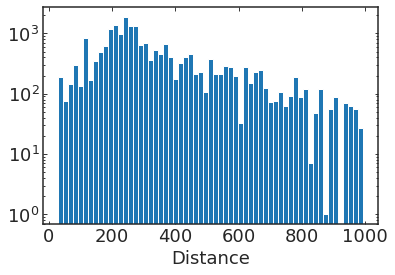

In [33]:
fig, ax=plt.subplots()
h=plt.hist(dfn.d, bins='auto', log=True)
ax.set(xlabel='Distance')

In [34]:
for g in dfn.groupby('spt_r'):
    print (g[0], len(g[1]))

16.0 139
17.0 551
18.0 1580
19.0 1026
20.0 861
21.0 1808
22.0 916
23.0 2067
24.0 1731
25.0 2146
26.0 1746
27.0 4775
28.0 1595


In [35]:
halo_bool=(dfn.population !='thin_disk').values

In [36]:
mags= popsims.pop_mags_from_type(np.random.uniform(10, 40, 1000),
                keys=['SDSS_R', 'SDSS_I', 'SDSS_Z'], reference='kiman2019')

In [37]:
zhang_mags={}
for k in ['SDSS_R', 'SDSS_I', 'SDSS_Z']:
    zhang_mags[k]=spe.typeToMag(np.random.uniform(10, 40, 1000), k,  reference='zhang2013')[0]

In [38]:
zhang_mags=pd.Series(zhang_mags)

[Text(0.5, 0, 'r-i'), Text(0, 0.5, 'i-z'), (0.0, 3.0), (0.0, 3.0)]

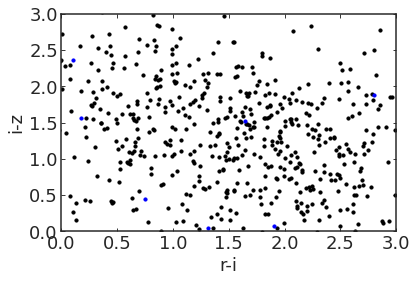

In [39]:
fig, ax=plt.subplots()
ax.scatter(mags.abs_SDSS_R-mags.abs_SDSS_I, \
           mags.abs_SDSS_I-mags.abs_SDSS_Z,s=10, c='k')

ax.scatter(zhang_mags.SDSS_R-zhang_mags.SDSS_I, \
           zhang_mags.SDSS_I-zhang_mags.SDSS_Z,s=10, c='b')


ax.set(xlabel='r-i', ylabel='i-z', xlim=[0, 3], ylim=[0,3])


In [40]:
#dfn

In [41]:
dfn_coord=SkyCoord(l=dfn.l*u.degree, b=dfn.b*u.degree, frame='galactic')

In [42]:
dfn['ra']=dfn_coord.icrs.ra.to(u.degree)
dfn['dec']=dfn_coord.icrs.dec.to(u.degree)

In [43]:
#popsims.galaxy.get

In [44]:
tqdm.pandas()
motion_df=dfn[['ra', 'dec', 'd', 'U', 'V', \
       'W' ]].progress_apply(lambda x: popsims.galaxy.get_proper_motion(*x), axis=1).reset_index(drop=True)

100%|██████████| 20941/20941 [01:50<00:00, 188.85it/s]


In [45]:
motion_halo=pd.DataFrame( popsims.galaxy.get_proper_motion_cylindrical(dfn.ra.values, \
                             dfn.dec.values,
                            (dfn.d.values)/1000,
                             dfn.Vr.values,
                            (dfn.Vphi.values)/(dfn.d.values+8300.*u.pc.to(u.km)),
                            dfn.Vz.values))

In [46]:
#len(dfj)==len(dfn)

In [47]:
dfn=dfn.reset_index(drop=True)

In [48]:
dfj=dfn.join(motion_df).reset_index(drop=True)

In [49]:
halo_bool=dfj.population=='halo'

In [50]:
#computer proper motions for halo star
dfj.loc[halo_bool, 'RV'] = motion_halo[halo_bool]['RV'].values
dfj.loc[halo_bool, 'mu_alpha'] = motion_halo[halo_bool]['mu_alpha'].values
dfj.loc[halo_bool, 'mu_delta']= motion_halo[halo_bool]['mu_delta'].values

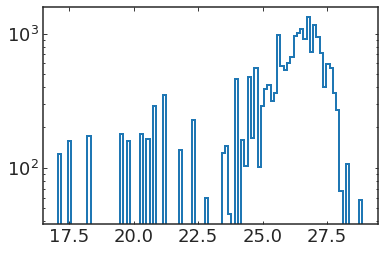

In [51]:
fig, ax=plt.subplots()
for k in PS1_DEPTHS.keys():
    #h=plt.hist(df['PANSTARRS_{}'.format(k)], bins='auto', histtype='step',\
    #           lw=2, log=True, linestyle='--')
    h=plt.hist(dfn['PANSTARRS_{}'.format(k)].values, bins='auto',\
               histtype='step', lw=2, log=True)

In [52]:
dfj.columns

Index(['VISTA_Z', 'abs_VISTA_Z', 'VISTA_Y', 'abs_VISTA_Y', 'VISTA_J',
       'abs_VISTA_J', 'VISTA_H', 'abs_VISTA_H', 'VISTA_KS', 'abs_VISTA_KS',
       'UKIDSS_Z', 'abs_UKIDSS_Z', 'UKIDSS_Y', 'abs_UKIDSS_Y', 'UKIDSS_J',
       'abs_UKIDSS_J', 'UKIDSS_H', 'abs_UKIDSS_H', 'UKIDSS_K', 'abs_UKIDSS_K',
       'SDSS_R', 'abs_SDSS_R', 'SDSS_I', 'abs_SDSS_I', 'SDSS_Z', 'abs_SDSS_Z',
       'PANSTARRS_R', 'abs_PANSTARRS_R', 'PANSTARRS_Z', 'abs_PANSTARRS_Z',
       'PANSTARRS_I', 'abs_PANSTARRS_I', 'PANSTARRS_Y', 'abs_PANSTARRS_Y',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W', 'population', 'Vr', 'Vphi', 'Vz',
       'abs_2MASS_J', 'abs_2MASS_H', 'abs_2MASS_K', '2MASS_J', '2MASS_H',
       '2MASS_K', 'abs_2MASS_KS', '2MASS_KS', 'spt_r', 'ra', 'dec', 'RV',
       'mu_alpha', 'mu_delta',

In [53]:
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    dfj['redH_{}'.format(k)]=dfj['abs_{}'.format(k)]+\
     5*np.log10((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)+5

[Text(0.5, 0, 'Reduced Proper Motion')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


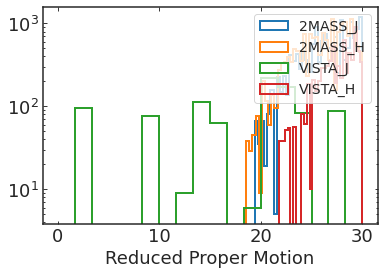

In [54]:
fig, ax=plt.subplots()
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    vals=dfj['redH_{}'.format(k)].values
    h=plt.hist(popsims.dropnans(vals),\
               bins='auto', histtype='step', lw=2, 
               log=True, label=k, range=[0, 30])
plt.legend(fontsize=14)
ax.set(xlabel='Reduced Proper Motion')

[None,
 None,
 Text(0.5, 0, 'Proper motion (mas/yr)'),
 Text(0, 0.5, 'Distance (pc)')]

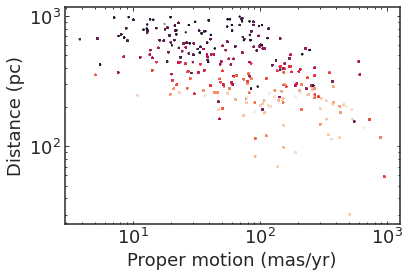

In [55]:
fig, ax=plt.subplots()

h=ax.scatter((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5, dfj.d,  c=dfj.spt, s=1, alpha=0.5)
ax.set(xscale='log', yscale='log', xlabel='Proper motion (mas/yr)', \
       ylabel='Distance (pc)', )

In [56]:
#(dfj['VISTA_J']-dfj['VISTA_KS']).min()

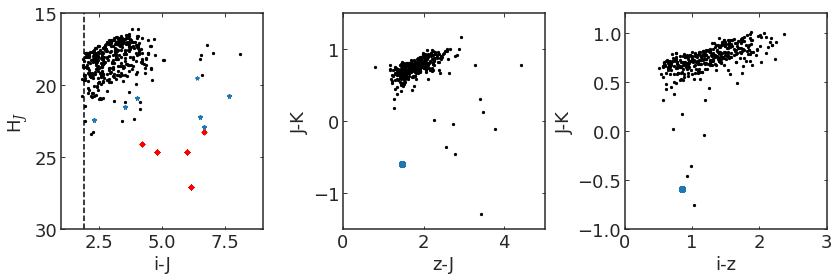

In [135]:
### color-color plots
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)


ax[0].scatter((dfj.SDSS_I[dfj.population=='thick_disk']-\
                dfj['VISTA_J'][dfj.population=='thick_disk']), \
           dfj['redH_{}'.format('VISTA_J')][dfj.population=='thick_disk'], s=10, \
           label='thick disk', marker='*')
ax[0].scatter((dfj.SDSS_I[dfj.population=='halo']-\
            dfj['VISTA_J'].loc[dfj.population=='halo']), \
           dfj['redH_{}'.format('VISTA_J')].loc[dfj.population=='halo'], \
           s=10, label='halo stars', color='r',
              marker='D')
ax[0].scatter((dfl_conct.SDSSi-dfl_conct.Jmag_VHS).values, \
                dfl_conct.Hj, s=5, c='k', label='Crossmatches')



ax[1].scatter((dfj.SDSS_Z[dfj.population=='thick_disk']-\
                dfj.VISTA_J[dfj.population=='thick_disk']), 
          (dfj.VISTA_J[dfj.population=='thick_disk']-\
                dfj.VISTA_KS[dfj.population=='thick_disk']),
           label='thick disk')
ax[1].scatter((dfj.SDSS_Z[dfj.population=='halo']-\
                dfj.VISTA_J[dfj.population=='halo']), 
          (dfj.VISTA_J[dfj.population=='halo']-\
                dfj.VISTA_KS[dfj.population=='halo']),
           s=10, label='halo stars', color='r',
              marker='D')
ax[1].scatter((dfl_conct.SDSSz-dfl_conct.Jmag_VHS).values, \
              (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS).values, s=5, c='k', label='Crossmatches')



ax[-1].scatter((dfj.SDSS_I[dfj.population=='thick_disk']-\
                dfj.SDSS_Z[dfj.population=='thick_disk']), 
          (dfj['VISTA_J'][dfj.population=='thick_disk']-\
                dfj['VISTA_KS'][dfj.population=='thick_disk']),
           label='thick disk')
ax[-1].scatter((dfj.SDSS_I[dfj.population=='halo']-\
                dfj.SDSS_Z[dfj.population=='halo']), 
          (dfj['VISTA_J'][dfj.population=='halo']-\
                dfj['VISTA_KS'][dfj.population=='halo']),
           s=10, label='halo stars', color='r',
              marker='D')
ax[-1].scatter((dfl_conct.SDSSi-dfl_conct.SDSSz).values, \
              (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS).values, s=5, c='k', \
               label='Crossmatches')

ax[0].set(xlabel='i-J',ylabel=r'H$_J$', xlim=[1., 9], ylim=[30, 15])
ax[0].axvline(1.9, color='k', linestyle='--')
ax[1].set(xlabel='z-J', ylabel='J-K', xlim=[0, 5], ylim=[-1.5, 1.5])
ax[-1].set(xlabel='i-z', ylabel='J-K', xlim=[0, 3], ylim=[-1, 1.2])

plt.tight_layout()
plt.savefig(popsims.FIGURES+'/simulatedcolors_sdss_vhs.pdf')

In [102]:
#

In [58]:
dfj['selection_function']=1.

In [59]:
#df['selection_function']=tot_bools

In [60]:
def get_ncounts(binby='spt', grid=np.arange(15, 40),
               population='thin_disk', df=None):
    
    df=(df[df.population==population]).reset_index(drop=True)
    scale=[df.scale.mean(), df.scale_unc.mean(),df.scale_times_model.mean()]
    NSIM=dict(zip(grid, np.zeros((len(grid), 2))))
    
    df['r_{}'.format(binby)]=df[binby].apply(np.round)
    df=df[df['r_{}'.format(binby)].isin(grid)].reset_index(drop=True)

    for g in tqdm(df.groupby('r_{}'.format(binby))):
        
        sn= len(df[np.logical_and(df.temperature>=450, df.temperature<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        
        #if sd:
        #    b0=np.logical_and(df.temperature>=450, df.temperature<=2100)
        #    b1=df.population=='halo'
        #    nhalo=len(df[np.logical_and(b0, b1)])/sn
        #    scln=scln*nhalo

        
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].selection_function)*scln
    df.drop('r_{}'.format(binby), axis=1)
    return pd.DataFrame(NSIM).T.rename(columns={0: 'N', 1: 'Nunc'})

In [61]:
 #dfj

In [62]:

counts=get_ncounts(grid=grid, population='thin_disk', df=dfj)
thickcounts=get_ncounts(grid=grid,  population='thick_disk', df=dfj)
halocounts=get_ncounts(grid=grid,  population='halo', df=dfj)

0it [00:00, ?it/s]
100%|██████████| 13/13 [00:00<00:00, 181.20it/s]


In [63]:
#halocounts

In [64]:
import scipy.integrate as integrate

In [65]:
def compute_volume(spt, l, b, h=350):
    dmin=0
    dmax=max_distances[spt]
    if np.isnan(dmax):
        return np.nan
    else:
        ds=np.linspace(dmin, dmax, 1000)
        rd=np.sqrt( (ds * np.cos( b ) )**2 + popsims.Rsun * (popsims.Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
        zd=popsims.Zsun+ ds * np.sin( b - np.arctan( popsims.Zsun / popsims.Rsun) )
        rh=popsims.galactic_density(rd, zd, h)
        return {'thin': integrate.trapz(rh['thin']*(ds**2), x=ds), \
                'thick': integrate.trapz(rh['thick']*(ds**2), x=ds), \
                'halo': integrate.trapz(rh['halo']*(ds**2), x=ds)}
                

In [66]:
grid

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39])

In [67]:
volumes={}
for k in grid:
    vs={'thin': 0.0, 'thick': 0.0, 'halo': 0.0}
    for f in tqdm(footprint):
        l=f.galactic.l.radian
        b=f.galactic.b.radian
        v=compute_volume(k, l, b, h=350)
        vs['thin'] +=v['thin']
        vs['thick'] +=v['thick']
        vs['halo'] +=v['halo']
    volumes[k]=vs

100%|██████████| 1378/1378 [00:09<00:00, 141.40it/s]


In [68]:
#save this, takes too much time to do
volumes_df=pd.DataFrame(volumes).T/len(footprint)

In [69]:
area=5350*(u.degree**2).to(u.radian**2)*(u.radian**2)
area_to_degree=area.to(u.degree**2)

In [70]:
area_to_degree

<Quantity 5350. deg2>

In [71]:
#volumes

In [72]:
#easiest ay is to compute volumes for every field and then
#second easiest thing, simulate an entire sky and do 2d-interpolation over sdss area

In [73]:
#counts['volume']=pd.Series(volumes).T/len(dfn_coord)
#sdcounts['volume']=pd.Series(volumes).T/len(dfn_coord)

In [74]:
counts.N.median()

0.0

[Text(0, 0.5, 'N/radian$^2$')]

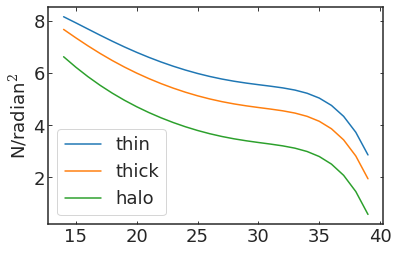

In [75]:
fig, ax=plt.subplots()
volumes_df.thin.apply(np.log10).plot(label='thin', ax=ax)
volumes_df.thick.apply(np.log10).plot(label='thick', ax=ax)
volumes_df.halo.apply(np.log10).plot(label='halo', ax=ax)
ax.legend()
ax.set(ylabel=r'N/radian$^2$')



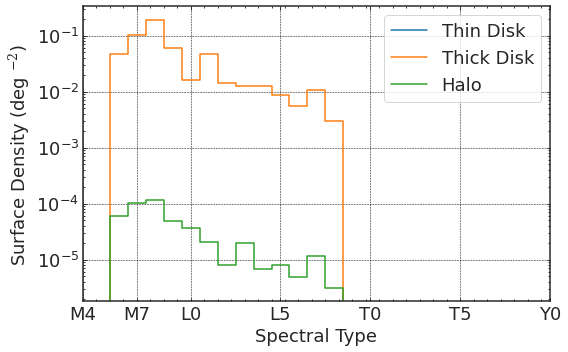

In [76]:
fig, ax=plt.subplots(figsize=(8, 5))

ax.step(counts.index, (counts.N.values*volumes_df.thin.values*area.value/(area)).to(u.deg**-2), \
        label='Thin Disk', where='mid')
ax.step(thickcounts.index, (thickcounts.N.values*0.12*volumes_df.thick.values*area.value/area).to(u.deg**-2),\
        label='Thick Disk', where='mid')
ax.step(halocounts.index,  (halocounts.N.values*0.0025*volumes_df.halo.values*area.value/area).to(u.deg**-2),\
        label='Halo', where='mid')
ax.set( xlabel='Spectral Type',  ylabel=r'Surface Density (deg $^{-2}$)', yscale='log', xlim=[14, 40] )
ax.grid()
#ax.axhline(100, linestyle='--', c='k')
plt.legend()
plt.tight_layout()
ax.minorticks_on()
ax.set_xticks([14, 17, 20,  25, 30, 35, 40])
ax.set_xticklabels(['M4', 'M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])
plt.savefig(popsims.FIGURES+'/simulatedncounts_sdss_vhs.pdf')

In [77]:
np.nansum((thickcounts.N.values*0.12*volumes_df.thick.values*area.value/area).to(u.deg**-2))

<Quantity 0.53468279 1 / deg2>

In [78]:
0.14*10,000

(1.4000000000000001, 0)

In [79]:
#read in a metal-poor baraffe model
#baraffe=pd.read_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998.csv')
#metpoor=(baraffe[baraffe.metallicity<0]).reset_index(drop=True)

In [80]:
#metpoor.to_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998_metalpoor.csv', index=False)